# Is It Getting Drier?

Fire season is [getting longer](https://climate.nasa.gov/news/2315/study-fire-seasons-getting-longer-more-frequent/) according to [an article][1] by [Matt Jolly of the Missoula Fire Sciences Laboratory](https://www.firelab.org/profile/jolly-matt). But is it getting drier also?

First, I'll look at the season average water vapor pressure deficit. There are many moisture variables that I could look at such as: absolute humidity or mixing ratio, relative humidity, dew point, and precipitable water. However, vapor pressure deficit is closely related to the rate of drying and moistness of fuels, which is why it was used for the [Hot-Dry-Windy Index](https://www.hdwindex.org/abouthdw.html#vpd). 

I defined season for the northern Rockies region as June through October. This is longer (in my experience) than the typical fire season, but if the fire seasons are getting longer as discussed in [Jolly, 2015][1], then we should see a trend in increasing season average vapor pressure deficit. 

[1]: https://www.nature.com/articles/ncomms8537

## Data

For data I used the [Global Hourly - Integrated Surface Data][2] from NCEI. I needed temperature and dew point or relative humidity from the data in order to calculate the vapor pressure deficit. I used some python code I wrote for this project to build a small database with observations and then be able to query it later. The python modules archive.py and data_import.py were used to build the database.

The season average vapor pressure deficit was calculated by averaging the hourly observations. If a season had hourly data for less than 90% of its hours, then no data point for that season was generated.

[2]: https://www.ncei.noaa.gov/products/land-based-station/integrated-surface-database

## Methods

Since I'm trying to answer a simple question, ("Is it getting drier?"), I'll use a simple model. I'll fit a linear trend to the time series of the season average vapor pressure deficit. However, a linear fit alone is not that informative because it can be very sensitive to the data points. Especially when we expect there to be a lot of scatter around the line.

So for this I'll use Bayesian methods to do the fit. The benefit of using Bayesian methods is that it not only gives me the slope of the trend line, but it gives me a probability distribution for what values it might take on given the data. With that probability distribution, I evaluate the probability that the trend line has a slope above zero. The probability that the slope of the trend line is positive is the probability that it is, on average, getting drier. The model is actually more complicated than that due to constraints on the values of season average vapor pressure deficit. I'll address the complications and their consequences below.

Bayesian methods are new to me, and I recently learned through reading [Think Bayes][3] and watching the [recorded lectures of Richard McElreath][4].

[3]: https://www.oreilly.com/library/view/think-bayes-2nd/9781492089452/
[4]: https://www.youtube.com/playlist?list=PLDcUM9US4XdMROZ57-OIRtIK0aOynbgZN

In [1]:
import archive
from project_utilities import Normalization, normalize_var, scale_var, get_monthly_average_vpd
from formulas import vapor_pressure_liquid_water

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cmdstanpy as stan
from datetime import datetime
import itertools

%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")

Import versions for libraries imported by archive
sqlite3: 2.6.0
tqdm   : 4.64.1

Import versions for libraries imported by project_utilities
pandas    : 1.5.1
arviz     : 0.13.0
matplotlib: 3.6.2
cartopy   : 0.21.0
numpy     : 1.23.4



In [2]:
# Connect to the archive.
arch = archive.Archive()
start = datetime(1940, 1, 1)
end = datetime(2021, 12, 31)

## Missoula, Montana (KMSO)

Loading the data for Missoula, Montana we see we have data for 65 years covering a 73 year period from 1948 through 2021.

In [3]:
# Load the data
data = get_monthly_average_vpd(arch, 'kmso', months=(6, 7, 8, 9, 10), starting=start, ending=end)
df = pd.DataFrame(data, columns=['lat', 'lon', 'elev', 'year', 'avg_vpd'])

x_norm = normalize_var(df, 'year', 'x_obs')
y_vpd_norm = scale_var(df, 'avg_vpd', 'y_vpd_obs')

df

,lat,lon,elev,year,avg_vpd,x_obs,y_vpd_obs
0,46.920787,-114.09292,973.2,1948,7.930213,-1.730658,0.782682
1,46.920787,-114.09292,973.2,1949,10.935978,-1.685462,1.079340
2,46.920787,-114.09292,973.2,1950,8.792123,-1.640266,0.867750
3,46.920787,-114.09292,973.2,1951,8.934594,-1.595070,0.881811
4,46.920787,-114.09292,973.2,1952,10.826581,-1.549874,1.068543
...,...,...,...,...,...,...,...
60,46.920787,-114.09292,973.2,2017,12.867476,1.387864,1.269972
61,46.920787,-114.09292,973.2,2018,10.676712,1.433060,1.053752
62,46.920787,-114.09292,973.2,2019,9.882396,1.478256,0.975356
63,46.920787,-114.09292,973.2,2020,10.660044,1.523452,1.052106


In [4]:
rise = df['y_vpd_obs'].max() - df['y_vpd_obs'].min()
run = df['x_obs'].max() - df['x_obs'].min()
print(f"rise: {rise} , run {run} , max-slope {rise / run}")

rise: 0.6782792561526783 , run 3.299306226609777 , max-slope 0.20558238901323458


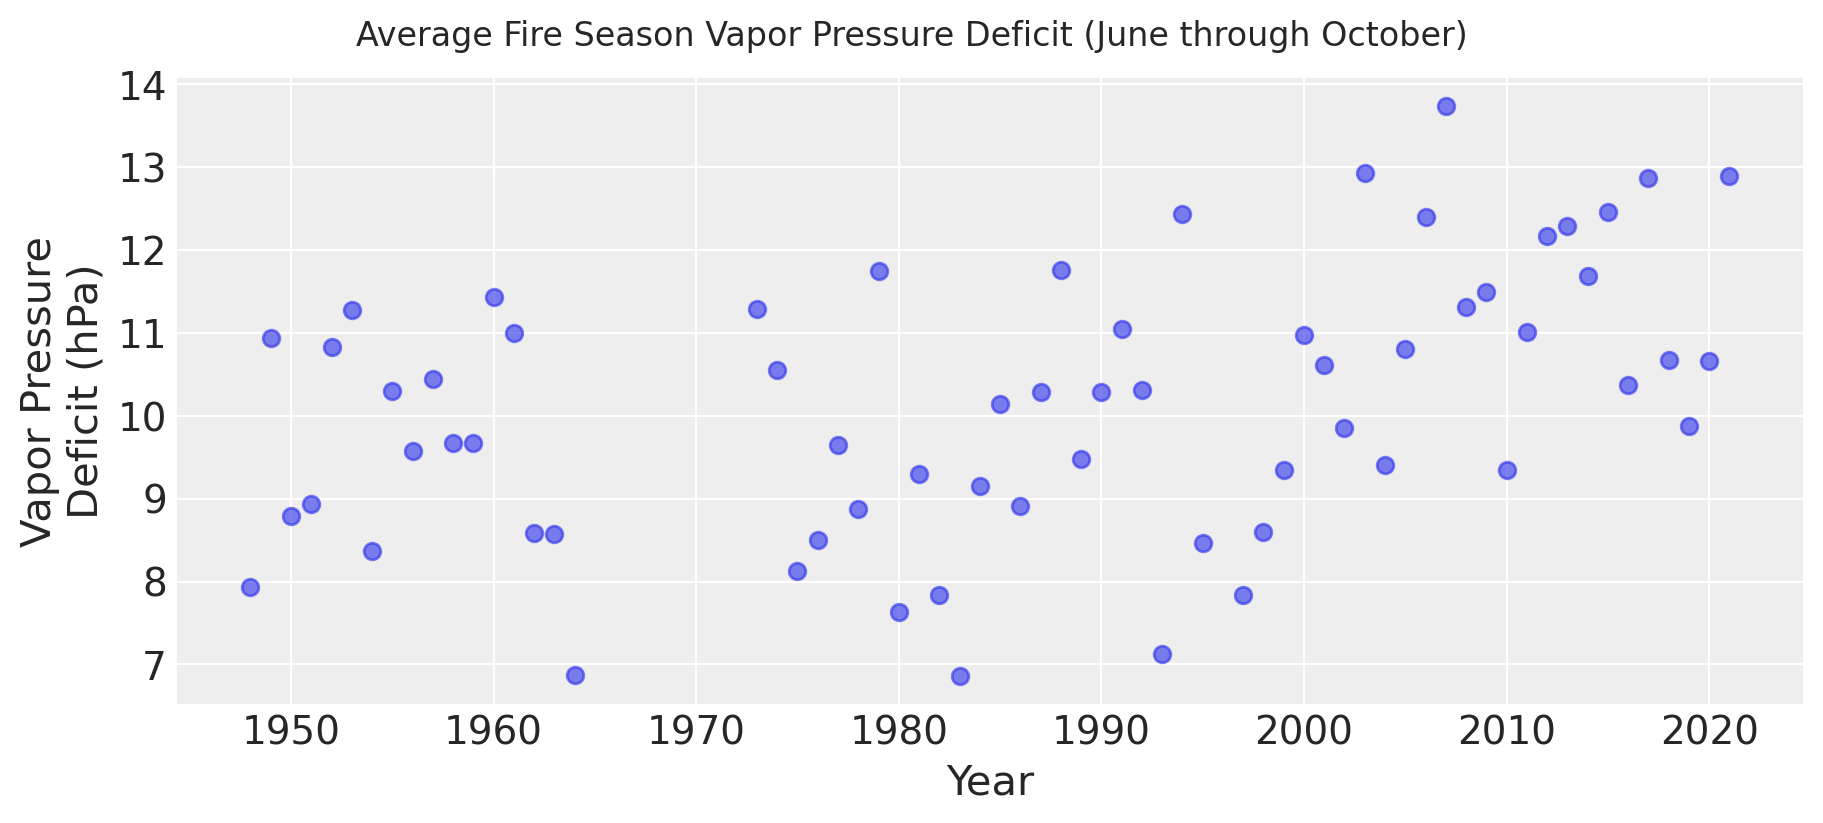

In [5]:
# Plot the data before we start trying to do a fit. Just look at the raw data.
fig, ax_vpd = plt.subplots(1, 1, sharex=True, figsize=(9,4));
fig.suptitle('Average Fire Season Vapor Pressure Deficit (June through October)');

ax_vpd.scatter(x_norm.denorm(df['x_obs']), y_vpd_norm.denorm(df['y_vpd_obs']), alpha=0.6);
ax_vpd.set_ylabel('Vapor Pressure\nDeficit (hPa)');
ax_vpd.set_xlabel('Year');

### The Model

To do the linear fit we'll build a model and evaluate it using the [PyMC](https://www.pymc.io/welcome.html) library. Bayesian models take more computational power than similar frequentist methods, but in the end you get the probability distribution for the potential values of your parameters instead of a single value.

A nice thing about these models is that the spread of the data around the trendline is built into the model.

For the model below, the 'beta' parameter is the slope of the trend line, which is what we're most interested in. The scatter of the points around the line is modeled with a Students-T distribution. I could have used a Gaussian distribution, but the Students-T distribution has fatter tails and is commonly used for "robust" estimation.

In [6]:
max_vpd = vapor_pressure_liquid_water(56.7)
max_vpd

171.29335156310162

## The Model

In [7]:
def link_function(x):
    return np.where(x > 0, x + 1.0 / 1000.0, np.exp(x) / 1000.0)

In [8]:
model = stan.CmdStanModel(
    model_name="missoula_prior", 
    stan_file="stan_files/missoula/missoula_prior.stan",
    cpp_options={"STAN_CPP_OPTIMS":"true"}
)

x_vals = x_norm.norm(np.arange(1948, 2022, 1))
prior_data = {"N": len(x_vals), "year": x_vals}
prior=model.sample(data=prior_data, chains=4, parallel_chains=4)

prior_idata = az.from_cmdstanpy(prior=prior, prior_predictive="prior_pred")
prior_idata

20:05:34 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:05:34 - cmdstanpy - INFO - CmdStan done processing.


Inference data with groups:
	> prior
	> prior_predictive
	> sample_stats_prior

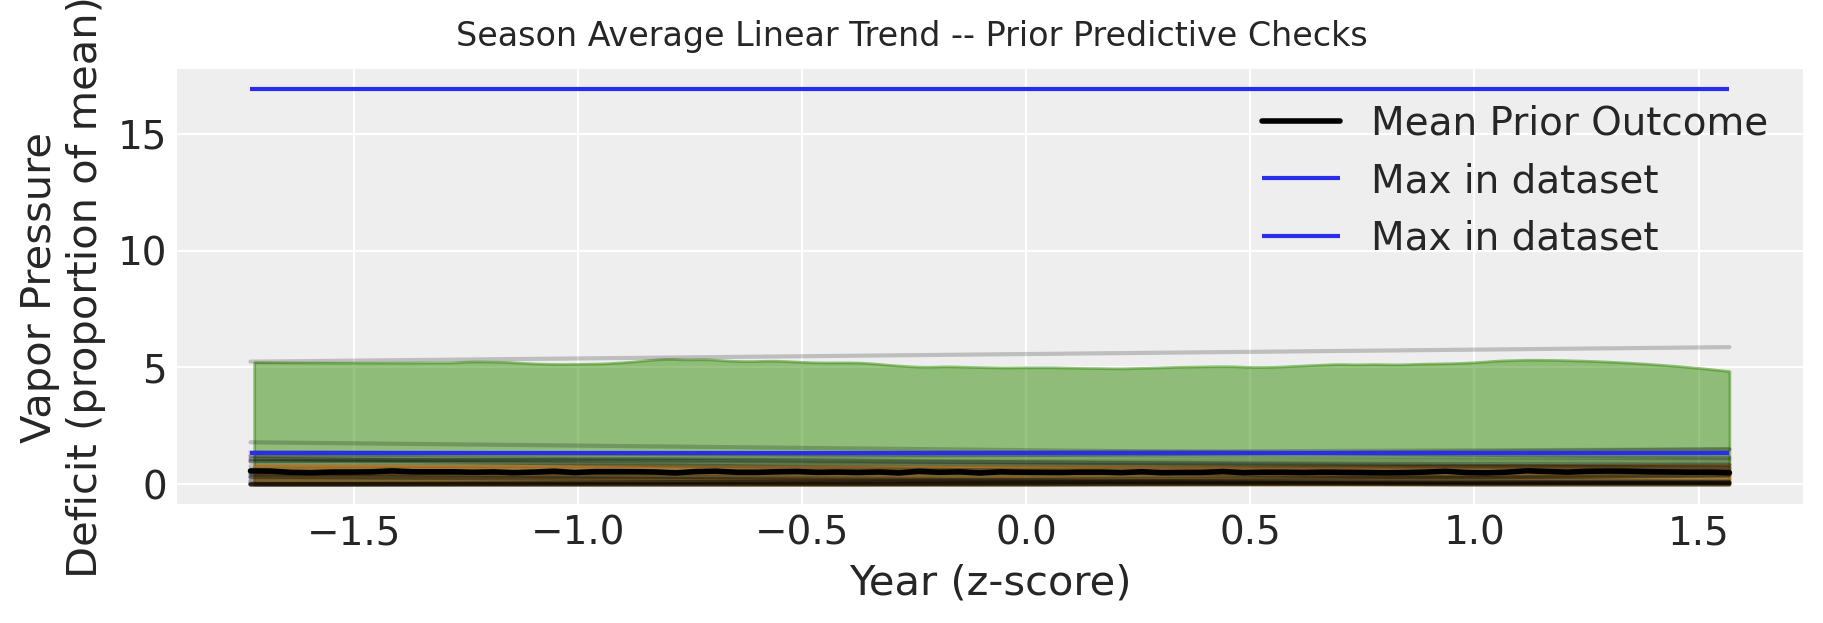

In [9]:
fig, ax_vpd  = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(9,3))
fig.suptitle("Season Average Linear Trend -- Prior Predictive Checks");

prior_vpd = prior_idata.prior.stack(chain_draw=('chain','draw'))

y_obs = prior_idata.prior_predictive.prior_pred

earliest = min(df['year'])
latest = max(df['year'])

# Plot the mean from the prior.
ax_vpd.plot(
    x_vals,
    y_obs.stack(chain_draw=('chain', 'draw')).mean(dim='chain_draw'),
    label="Mean Prior Outcome", 
    color='black', 
    alpha=1.0,
    lw=2
);

# Plot the high probability density interval for predictions from the model with the priors
# Using 99 percent here to determine that the prior covers the full range.
az.plot_hdi(
    x_vals,
    y_obs,
    color='C2',
    hdi_prob=0.99,
    ax=ax_vpd
);

# Plot the high probability density interval for predictions from the model with the priors
# Using 80 percent here to see that most of the priors' mass is below the extreme value max_vpd.
az.plot_hdi(
    x_vals,
    y_obs,
    color='C1',
    hdi_prob=0.80,
    ax=ax_vpd
);

# Plot several potential lines for the mean VPD.
a_s = prior_idata.prior["a"].stack(chain_draw=('chain','draw'))
by_s = prior_idata.prior["by"].stack(chain_draw=('chain','draw'))

a_by_pairs = tuple(itertools.islice(zip(a_s, by_s), 30))

for a, by in a_by_pairs:
    a, by = float(a), float(by)
    ys = link_function(a + by * x_vals)

    ax_vpd.plot(x_vals, ys, c="k", alpha=0.2)

# Plot the max_vpd as determined from prior information. This is a really high bound.
ax_vpd.hlines(df['y_vpd_obs'].max(), x_norm.norm(earliest), x_norm.norm(latest), 
              label="Max in dataset")
ax_vpd.hlines(y_vpd_norm.norm(max_vpd), x_norm.norm(earliest), x_norm.norm(latest), 
              label="Max in dataset")

ax_vpd.set_ylabel('Vapor Pressure\nDeficit (proportion of mean)');
ax_vpd.legend();

ax_vpd.set_xlabel('Year (z-score)');


In [10]:
model_post = stan.CmdStanModel(
    model_name="missoula_posterior", 
    stan_file="stan_files/missoula/missoula_posterior.stan",
    cpp_options={"STAN_CPP_OPTIMS":"true"}
)

x_vals = df['x_obs']
y_vals = df['y_vpd_obs']
post_data = {"N": len(x_vals), "year": x_vals, "vpd": y_vals}
post=model_post.sample(data=post_data, chains=4, parallel_chains=4)

post_idata = az.from_cmdstanpy(posterior=post, posterior_predictive=["post_pred", "mu"])
post_idata

20:05:44 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:05:44 - cmdstanpy - INFO - CmdStan done processing.
20:05:44 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: gamma_lpdf: Random variable is 0, but must be positive finite! (in '/home/ryan/programming/bayes-trends/stan_files/missoula/missoula_posterior.stan', line 21, column 2 to column 22)
	Exception: gamma_lpdf: Random variable is 0, but must be positive finite! (in '/home/ryan/programming/bayes-trends/stan_files/missoula/missoula_posterior.stan', line 21, column 2 to column 22)
	Exception: gamma_lpdf: Random variable is 0, but must be positive finite! (in '/home/ryan/programming/bayes-trends/stan_files/missoula/missoula_posterior.stan', line 21, column 2 to column 22)
	Exception: gamma_lpdf: Random variable is 0, but must be positive finite! (in '/home/ryan/programming/bayes-trends/stan_files/missoula/missoula_posterior.stan', line 21, column 2 to column 22)
	Exception: gamma_lpdf: Random variable is 0, but must be positive finite! (in '/home/ryan/programming/b

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats

### Diagnostics

The charts below are used to diagnose how the MCMC algorithm worked in sampling the posterior distribution. It all looks good to me.

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,0.999,0.019,0.963,1.033,0.0,0.0,3224.599,2921.165,1.000
by,0.063,0.019,0.027,0.098,0.0,0.0,2999.643,1858.504,1.005
sigma,0.152,0.014,0.127,0.180,0.0,0.0,2807.519,2293.948,1.002


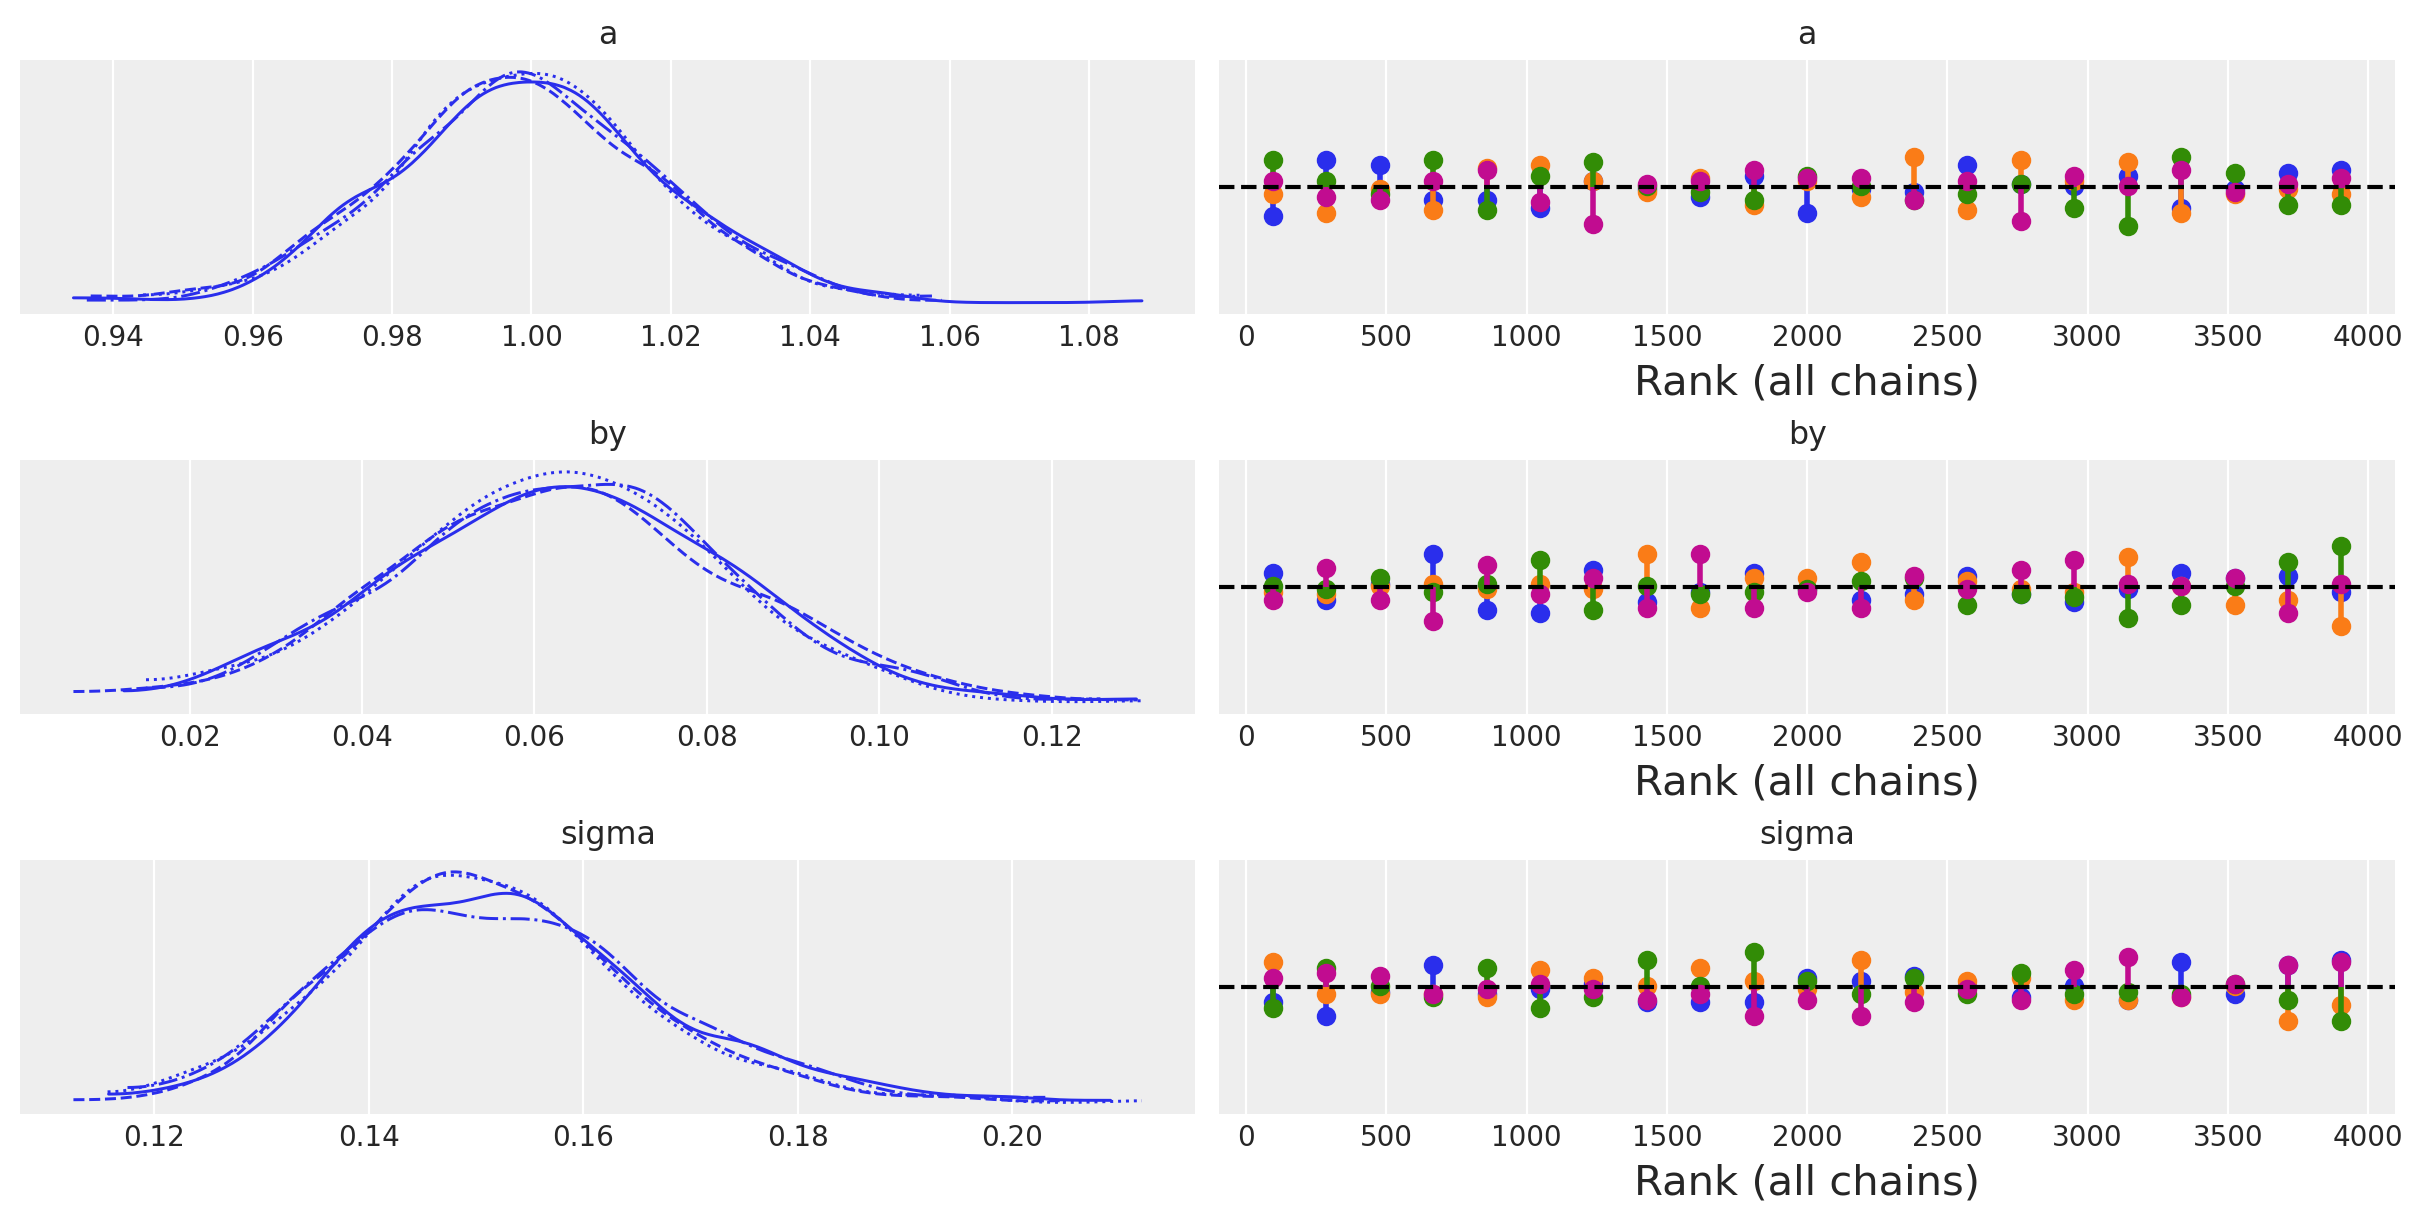

In [11]:
az.plot_trace(post_idata, kind='rank_vlines');
az.summary(post_idata, round_to=3)

### Missoula Results

Below are the probability distributions for the values in the model.

#### Alpha

"alpha" is just the intercept in the model. I don't really care about this value as it doesn't tell me anything useful. It's so closely distributed around zero because we normalized the data before fitting the model.

#### Beta

"beta" is the slope of the trend line (for the normalized data). This is what I'm interested in. Is it increasing or decreasing? The orange vertical line is a reference line for 0.0, and 99.9% of the distribution for potential slopes is above 0.

#### Sigma and Nu

These parameters describe the spread of the observations around the trend line. I'm not as familiar with these parameters as I am with the standard deviation that I could have gotten if I used a Gaussian distribution in the model for the spread of the data around the line. I'll make a plot below to help visualize that.

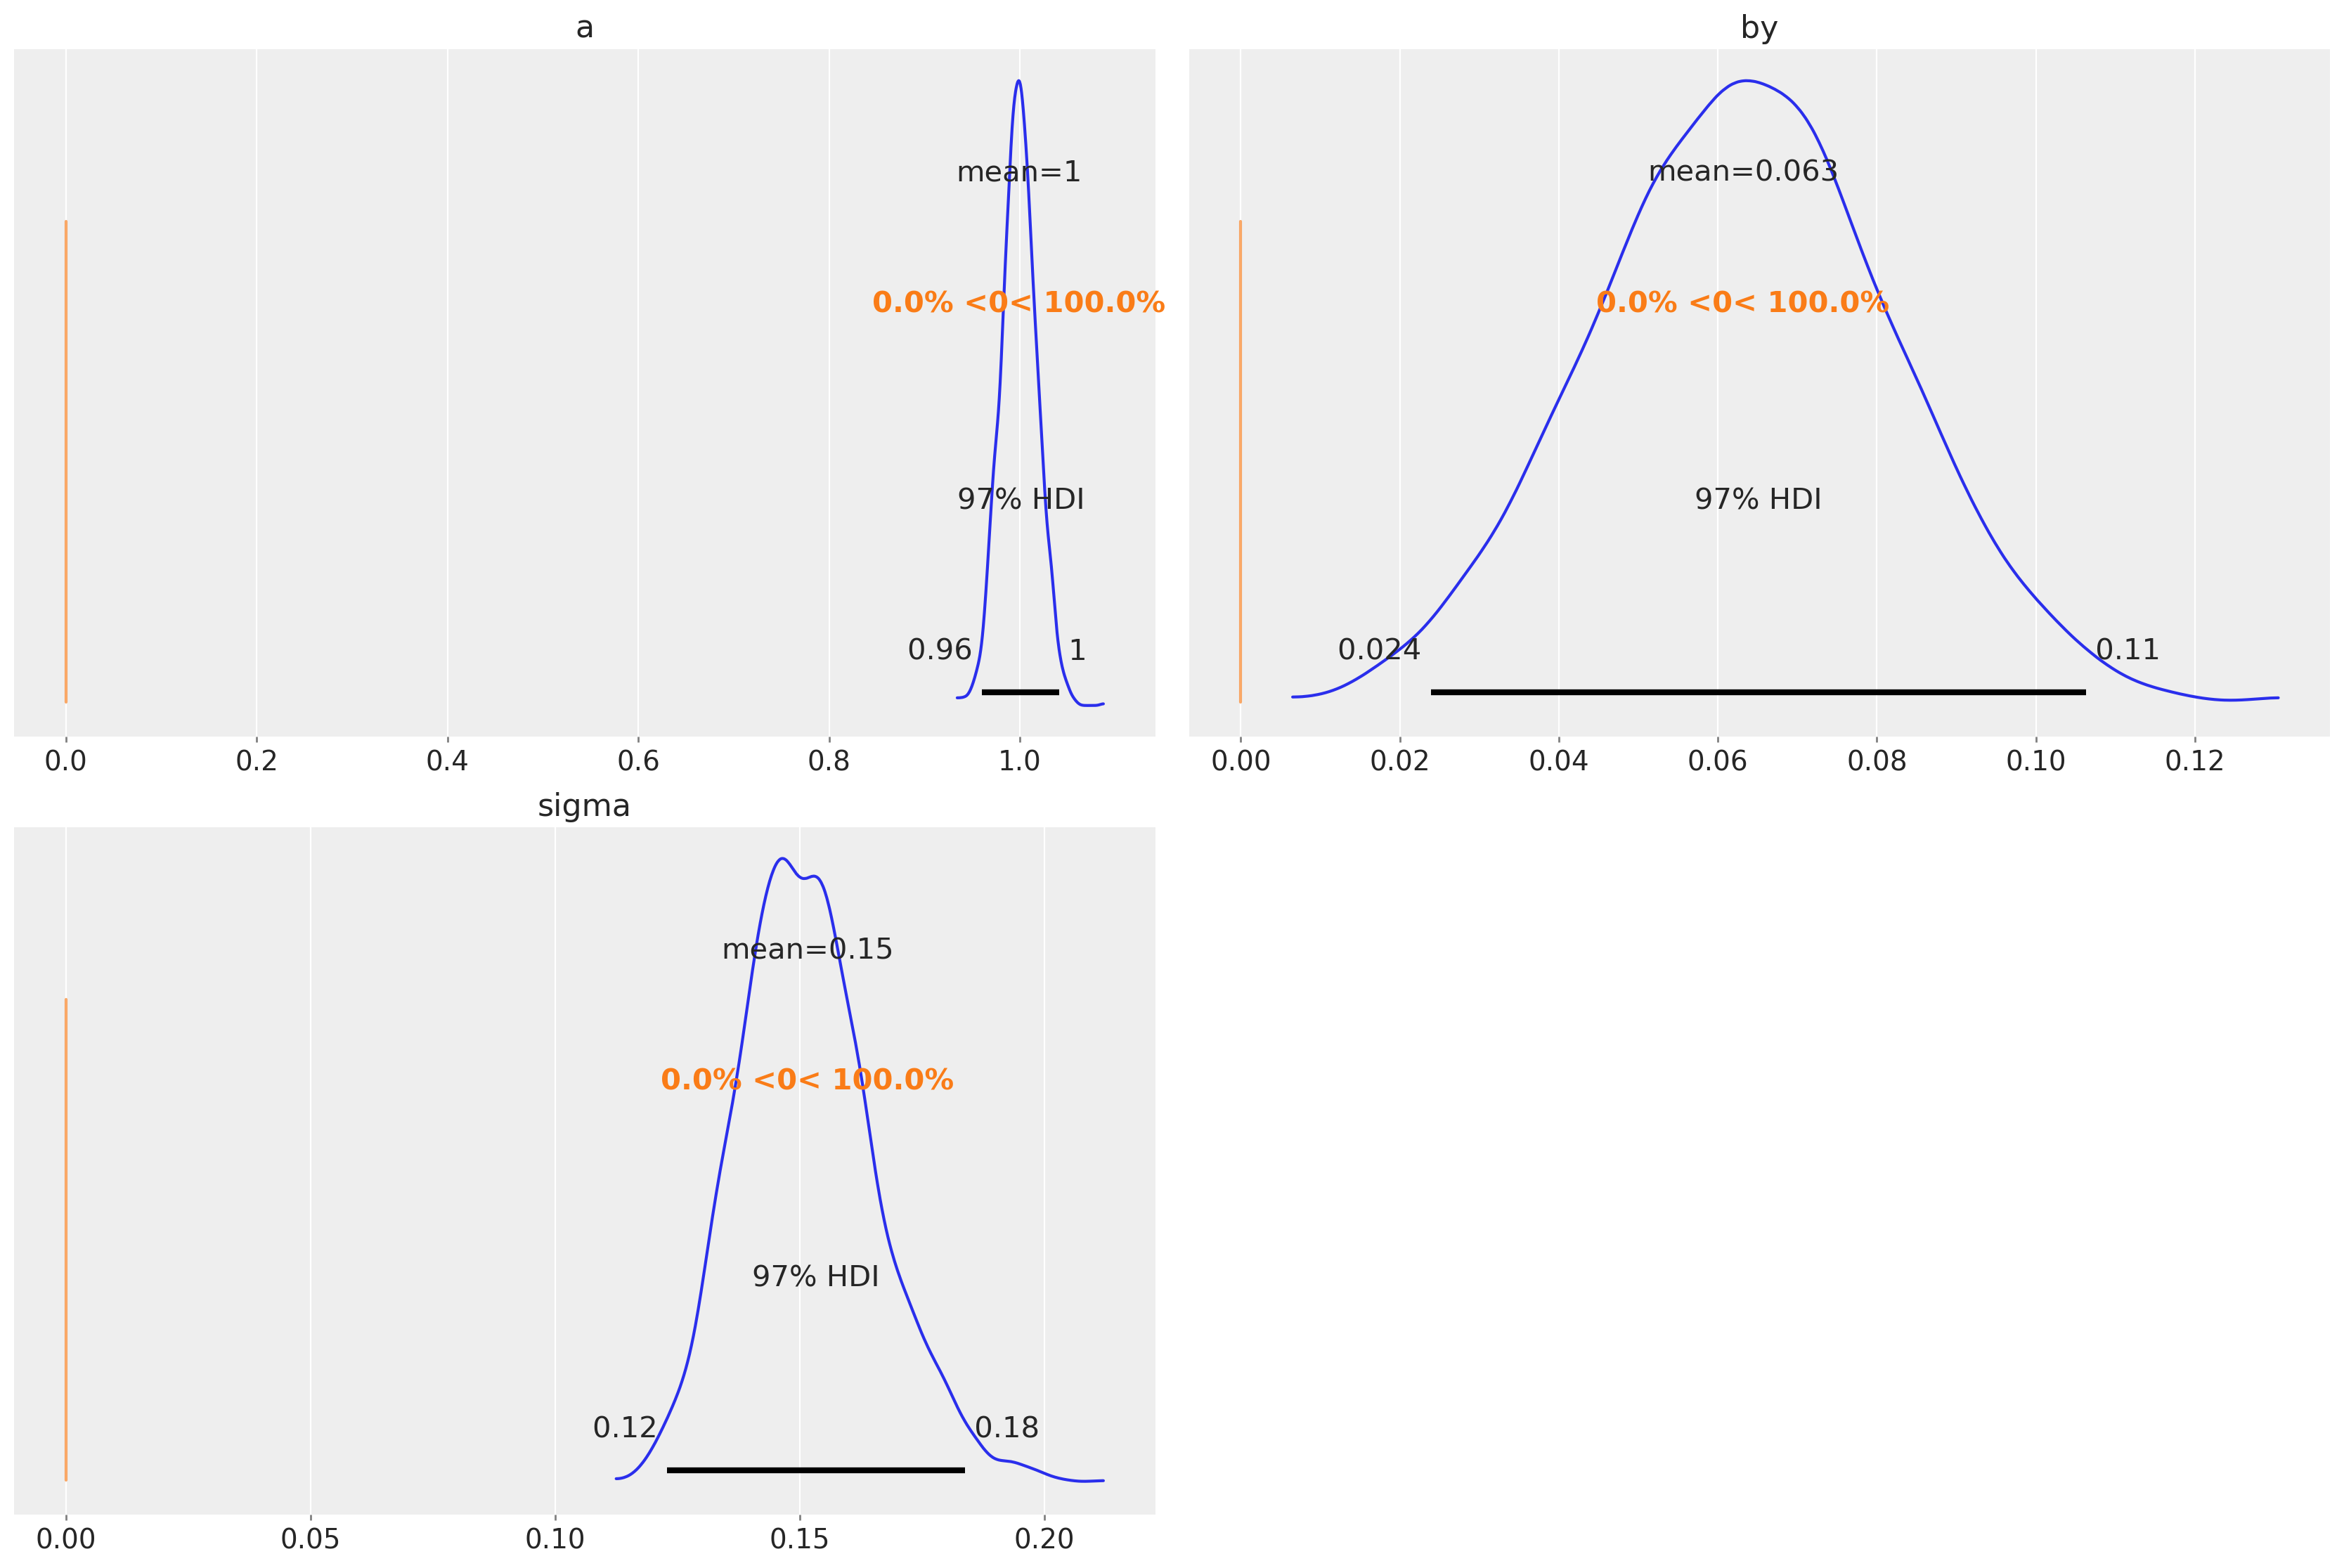

In [12]:
az.plot_posterior(post_idata, grid=(2,2), hdi_prob=0.97, ref_val=0.0, var_names=["a", "by", "sigma"]);

### Sampling the Posterior Predictive

In this step I use the model to generate several data points around the trend line. These use the trend line to come up with the background average vapor pressure deficit from the trend line, and then it generates many random values from the Student's-T distribution. It does everywhere there is a data point in the sample set. From the generated data I plot the range from the 3rd to the 97th percentile along with the mean linear fit line and the original data. 

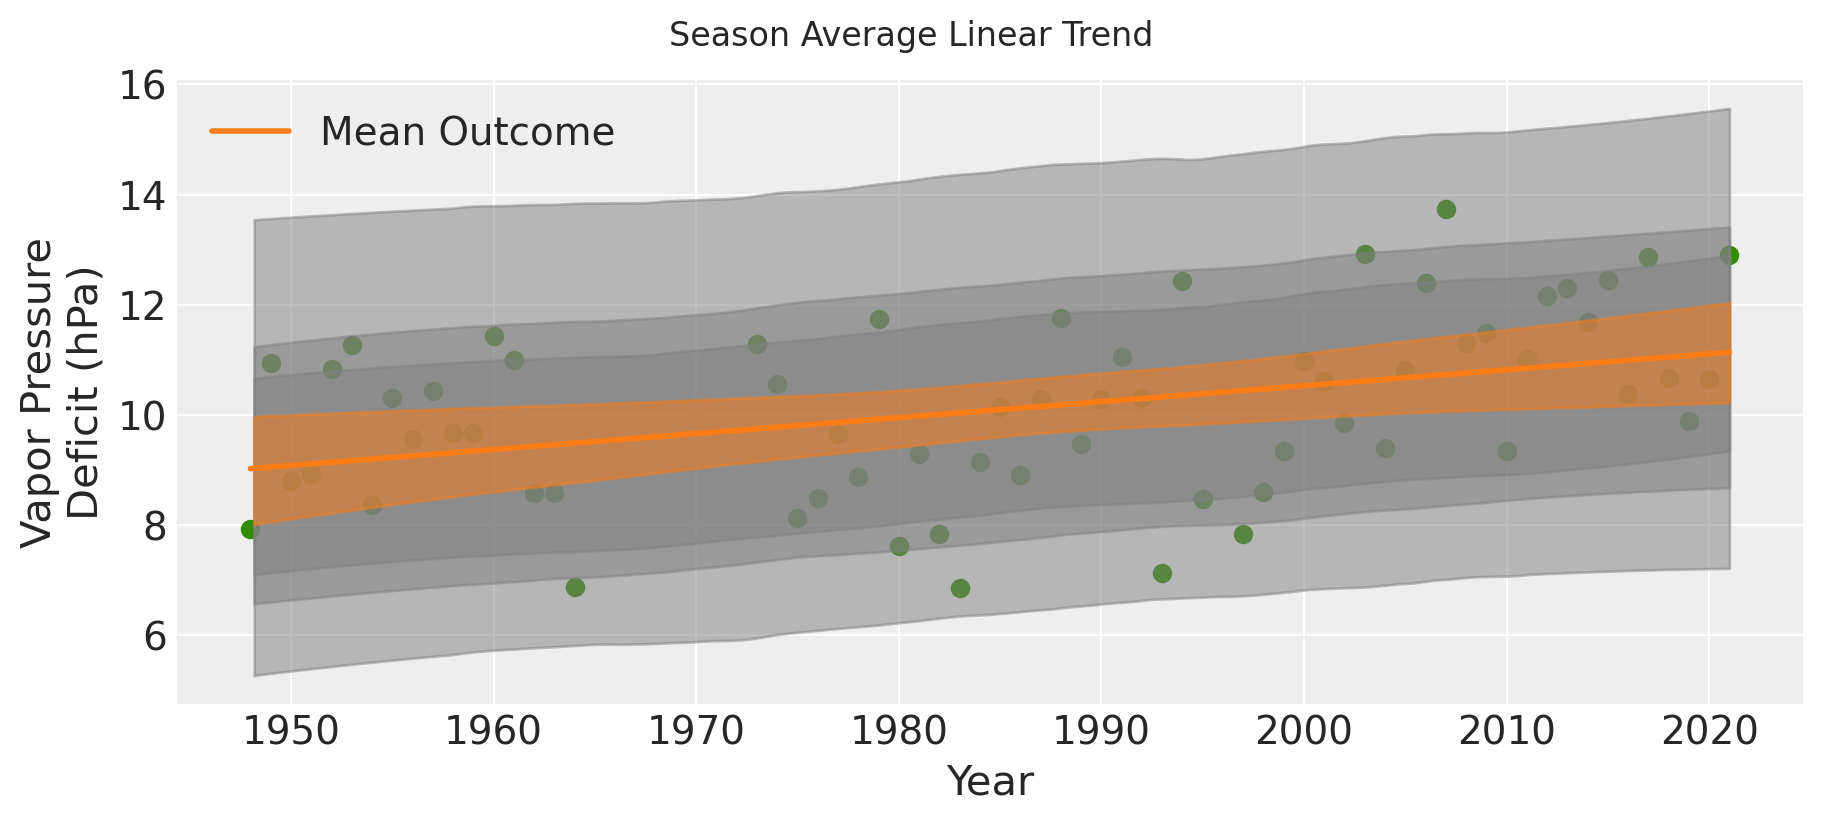

In [17]:
fig,  ax_vpd  = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(9,4))
fig.suptitle("Season Average Linear Trend");

# Plot vapor pressure deficit data with ranges and trends.

ax_vpd.scatter(
    x_norm.denorm(df['x_obs']),
    y_vpd_norm.denorm(df['y_vpd_obs']),
    color='C2'
);

az.plot_hdi(
    x_norm.denorm(df['x_obs']),
    y_vpd_norm.denorm(post_idata.posterior_predictive['post_pred']),
    color='gray',
    hdi_prob=0.99,
    ax=ax_vpd
);

az.plot_hdi(
    x_norm.denorm(df['x_obs']),
    y_vpd_norm.denorm(post_idata.posterior_predictive['post_pred']),
    color='gray',
    hdi_prob=0.87,
    ax=ax_vpd
);

az.plot_hdi(
    x_norm.denorm(df['x_obs']),
    y_vpd_norm.denorm(post_idata.posterior_predictive['post_pred']),
    color='gray',
    hdi_prob=0.75,
    ax=ax_vpd
);

az.plot_hdi(
    x_norm.denorm(df['x_obs']),
    y_vpd_norm.denorm(post_idata.posterior_predictive['mu']),
    color='C1',
    hdi_prob=0.99,
    ax=ax_vpd
);

ax_vpd.plot(
    x_norm.denorm(df['x_obs']), 
    y_vpd_norm.denorm(post_idata.posterior_predictive['mu'].mean(("draw", "chain"))), 
    label="Mean Outcome", 
    color='C1', 
    alpha=1.0,
    lw=2
)

ax_vpd.set_ylabel("Vapor Pressure\nDeficit (hPa)");
ax_vpd.set_xlabel("Year");
ax_vpd.legend();

Using the mean from the posterior distribution of the model paramters, I plotted the mean linear regression. Using that line, the background average season vapor pressure deficit in Missoula has increased from roughly 9 hPa to 11 hPa in about 70 years.